In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
from dataclasses import dataclass, field

/Users/Shared/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Shared/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/Shared/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <1047A1B2-1309-3AD3-9AF6-9F7508492890> /Users/Shared/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Hyperparameters
evaluating 10 quantiles, using 60% data for training, 15% for validation and the rest for testing<br>
<br>
filename: file name for the data<br>
beststate: file name to save the best model, inputed after entering config<br>
logdir: folder to store logged info (must end with "/"), enter empty string to store in the same folder as this file<br>
forecast: forecast horizon (no. of days ahead)<br>
numfeatures: no. of features in the data, inputed after loading data, 11 features in this case <br>
hidden: no. of hidden units for MLP<br>
batch:batch size <br>
lr: learning rate <br>
output: no. of outputs, 1 prediction+ 10 quantiles = 11 for this case, inputed after loading data


In [2]:
#Config Parameters
@dataclass
class Args:
    filename:str = "/Users/lixiang/Desktop/BTC Glassnode/BTC_data_daily.csv"
    beststate:str = None
    logdir:str = "./logs/"
    quantiles:list = field(default_factory = lambda:[0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
    trainfrac:float = 0.6
    valfrac:float = 0.15
    forecast:int = 2
    numfeatures:int = None
    hidden:int = 30
    batch:int = 16
    lr:float = 0.0002
    output:int = None
    dropout:float = 0.3
    epochs:int = 100

## Load Data
loads data and excludes dates

data is split into inputs (X) and labels(Y)

In [3]:
#Load & Split Data
def get_data(args):
    data = np.array(pd.read_csv(args.filename).iloc[:,1:]).astype("float32")
    torch.set_default_dtype(torch.float32)
    X = torch.tensor(data[:-args.forecast,:])
    Y = data[args.forecast:,-1]
    return X,Y

## Split Data
data is split into train, validation and testing sets using dataloader

In [4]:
def get_loader(X,Y,args):
    i_train = int(len(Y)*args.trainfrac)
    i_val = int(len(Y)*(args.valfrac+args.trainfrac))
    end = len(Y)
    train_iter = torch.utils.data.DataLoader(list(zip(X[:i_train],torch.tensor(Y[:i_train]))), batch_size=args.batch, shuffle = True)
    val_iter = torch.utils.data.DataLoader(list(zip(X[i_train:i_val],Y[i_train:i_val])), batch_size=args.batch, shuffle = False)
    test_iter = torch.utils.data.DataLoader(list(zip(X[i_val:end],Y[i_val:end])), batch_size=args.batch, shuffle = False)
    return train_iter, val_iter, test_iter, i_train, i_val

## Evaluation & Loss Functions
For the inputs to these functions, they are defined as follows:
1. $\hat{y}$: prediction with shape (sample size)  x (outputs = 1 mean + 10 quantiles)
2. $y$: observation, 1d vector, length = sample size
3. $\tau$: quantile vector of length (J=10)

$y$ and $\hat{y}$ are tensors for loss function and numpy array for evaluation functions.
<br>


In [5]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.mean(torch.square(y-ŷ[:,0]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1]
        loss += torch.mean(q*r - r*(r<0))
    return loss

similar metrics from DeepJMQR are reused here

In [6]:
#for evaluation: remember to turn tensors into np array
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1]
        loss += np.mean(q*r - r*(r<0))
    return loss

In [7]:
def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(ŷ.shape[1]-2):
        q = ŷ[:,i+1] - ŷ[:,i+2]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
#     loss /= ŷ.shape[2]
#     num_cross /= ŷ.shape[2]
    return loss, num_cross

In [8]:
def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

In [9]:
def eval_error(y, ŷ):
    r = np.abs(y-ŷ[:,0])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    correct_sign = np.mean(y*ŷ[:,0]<0)/(1-np.mean(y*ŷ[:,0]==0))
    return mse, rmse, mae, correct_sign

In [10]:
def eval(y, ŷ, quantiles):
    closs, num_cross = crossing_loss(ŷ)
    tloss = tilted_loss(quantiles, y, ŷ)
    mse, rmse, mae, correct_sign = eval_error(y, ŷ)
    icp, mil = [], []
    for i in range(len(quantiles)//2):
        t1,t2 = eval_quantiles(ŷ[:,i+1],ŷ[:,len(quantiles)-i],y)
        icp.append(f'{t1:.6f}')
        mil.append(f'{t2:.6f}')
    return f'{closs:.10f}', f'{num_cross:.0f}', f'{tloss:.10f}', f'{mse:.10f}', f'{rmse:.10f}', f'{mae:.10f}', f'{correct_sign*100:.6f}', icp, mil

In [11]:
def print_error(closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil, quantiles):
    performance = [closs, num_cross, tloss, mse, rmse, mae, correct_sign]
    predinterval = [[round((quantiles[len(quantiles)-i-1]-quantiles[i])*100) for i in range(len(quantiles)//2)], icp, mil]
    print("Crossing Loss:", closs, ", Number of Crosses:", num_cross)
    print("MSE:",mse, "RMSE:", rmse,"MAE:", mae)
    print("Tilted loss:", tloss)
    print("Prediction Intervals:")
    for i in range(len(quantiles)//2):
        print("{}% ICP:{}, MIL:{}".format(round((quantiles[len(quantiles)-i-1]-quantiles[i])*100),icp[i],mil[i]))
    print("the model predicts the sign correctly in", correct_sign,"% of the cases (excluding 0)")
    return performance, predinterval

batch normalization is used as the 1st layer to rescale the inputs <br>

In [12]:
#Initialize Model
def make_model(args):
    net = nn.Sequential(nn.BatchNorm1d(args.numfeatures, affine = True),
                        nn.Linear(args.numfeatures,args.hidden),     
                        nn.ReLU(),                    
                        nn.Dropout(args.dropout),
                        nn.Linear(args.hidden,args.hidden//2),
                        nn.ReLU(),
                        nn.Linear(args.hidden//2,args.output))
    return net

### Training / Validation
1. inputs data in batches into the model
2. make predictions
3. evaluates loss value & makes adjustment to parameters (when training) then returns average loss value across batches

the same function is reused for both training & validation

Reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

"The Training Loop" & "Per-Epoch Activity"

In [13]:
#Train & Val Model
def one_epoch(model, one_iter, quantiles, optimizer = None):
    running_loss = 0.0
    for i, data in enumerate(one_iter):
        inputs, labels = data
        outputs = model(inputs)
        loss = lossfn(quantiles, labels, outputs)
        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
#         last_loss = loss.item()
    return running_loss / (i+1)

## Main Training Function
0. get data, creates model, defines optimizer & animator (for visualization)
1. trains & validates the model
2. logs & visualizes training and validation loss 
3. saves the best performing model & returns the best model at the end

In [14]:
def train(X,Y,args):
    #0.
    train_iter, val_iter, test_iter, i_train, i_val = get_loader(X,Y,args)
    model = make_model(args)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = args.lr)
    animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,args.epochs], legend = ["train", "val"], figsize = (7,5))
    best_vloss = 1e9
    trainlogs = []
    for i in range(args.epochs):
        #1.
        model.train(True)
        avg_loss = one_epoch(model, train_iter, args.quantiles, optimizer=optimizer)
        model.eval()
        avg_vloss = one_epoch(model, val_iter, args.quantiles)
        #2.
        if i % (args.epochs//10) == args.epochs//10-1:
            trainlogs.append([i+1, f'{avg_loss:.10f}', f'{avg_vloss:.10f}'])
        animator.add(i+1, (avg_loss, avg_vloss))
        #3.
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model, args.beststate)
    model = torch.load(args.beststate)
    return model, trainlogs, i_train, i_val

### Log Training & Performance Info
1. training & validation loss
2. performance (crossing & tilted loss, RMSE, no. of crosses etc)
3. prediction intervals (ICP & MIL)

In [15]:
def log(args, tlogs, performance, predinterval):
    tlogs.columns = ["epoch", "train loss", "valid loss"]
    performance.columns = ["Crossing Loss", "No. of Crosses", "Tilted Loss", "MSE", "RMSE", "MAE", "Correct Sign (%)"]
    predinterval.columns = ["Prediction Interval(%)", "ICP", "MIL"]
    tlogs.to_csv(args.logdir+"MLP_trainlogs_daily_{}_{}_{}.csv".format(args.forecast, args.hidden, args.epochs))
    performance.to_csv(args.logdir+"MLP_performance_daily_{}_{}_{}.csv".format(args.forecast, args.hidden, args.epochs))
    predinterval.to_csv(args.logdir+"MLP_prediction_interval_daily_{}_{}_{}.csv".format(args.forecast, args.hidden, args.epochs))

## Main Body
1. loads inputs & outputs (X & Y)
2. fills in missing parameters (numfeatures, output, beststate)
3. trains the model
4. applies the model on validation data
5. evaluates & logs errors/performance

In [16]:
def explore(args):
    X,Y = get_data(args)
    args.numfeatures = X.shape[1]
    args.output = len(args.quantiles)+1
    args.beststate = "MLP_model_best_state_daily_{}_{}_{}".format(args.forecast, args.hidden, args.epochs)
    model, tlogs, i_train, i_val = train(X,Y,args)
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil = eval(Y_val, pred, args.quantiles)
    performance, predinterval = print_error(closs, num_cross, tloss, mse, rmse, mae, correct_sign, icp, mil, args.quantiles)
    log(args,pd.DataFrame(tlogs), pd.DataFrame(performance).transpose(), pd.DataFrame(predinterval).transpose())

### Visualization
by default, plots 5% & 95% quantiles and true value as these quantiles are often the most volatile ones so that it would be easier to observe whether the model captures changes in returns

input quantiles = arg.quantiles to show all quantiles

input mean = True to show mean prediction

specify starting & ending index to show part of the plot

input asset = values from 0 to 8 to view any quantile performance for all 9 assets

In [17]:
def visualize(args, quantiles = [0.05, 0.95], start = None, end = None, mean = False):
    index = [args.quantiles.index(x)+1 for x in quantiles]
    model = torch.load(args.beststate)
    X,Y = get_data(args)
    i_train, i_val = int(len(Y)*args.trainfrac), int(len(Y)*(args.valfrac+args.trainfrac))
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    if start == None:
        start = 0
    if end == None:
        end = len(Y_val)
    #temp: stores data to be plotted
    temp = Y_val[start:end]
    #quantiles: legend for the plot/column name for the dataframe
    quantiles = [f'{x*100:.0f}'+"%" for x in quantiles]
    quantiles.insert(0,"trues")
    for i in index:
        temp = np.vstack((temp,pred[start:end,i]))
    if mean:
        temp = np.vstack((temp,pred[start:end,0]))
        quantiles.insert(1,"mean")
    df = pd.DataFrame(temp.transpose())
    df.columns = quantiles
    df.plot(lw = 0.5, figsize = (8,6)).legend(fontsize = 9, ncol = len(df.columns)//3)

Crossing Loss: 0.0109260082 , Number of Crosses: 9
MSE: 0.0017915242 RMSE: 0.0423264019 MAE: 0.0257228576
Tilted loss: 0.0935348333
Prediction Intervals:
90% ICP:0.916933, MIL:0.132908
80% ICP:0.819489, MIL:0.087332
60% ICP:0.669329, MIL:0.051311
40% ICP:0.472843, MIL:0.028189
20% ICP:0.258786, MIL:0.012091
the model predicts the sign correctly in 48.562300 % of the cases (excluding 0)


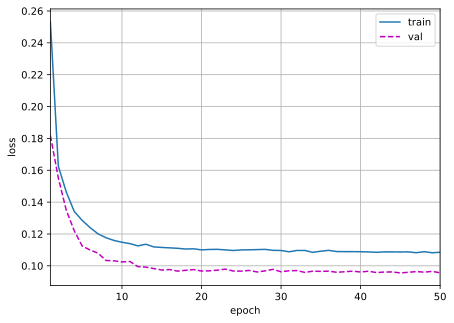

In [18]:
if __name__ == "__main__" and '__file__' not in globals():
    args = Args(forecast = 2, hidden = 50, epochs = 50, dropout = 0.3)
    explore(args)

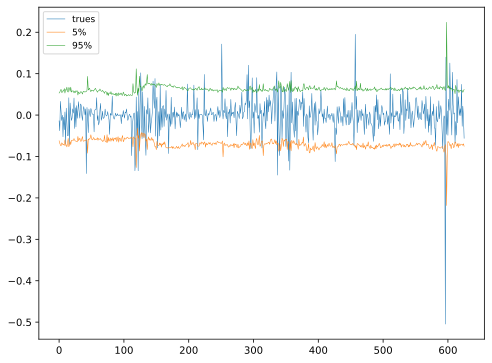

In [19]:
if __name__ == "__main__" and "__file__" not in globals():
    visualize(args)#, quantiles = args.quantiles)

### observations & comparison with Random Forest Regression
lower MAE compared to RF (0.04)<br>
might need to find more metrics for RF to make comparisons <br>
it seems like the model is able to capture spikes in returns (around x = 50, 150, 600), not sure whether it was a prediction or a reaction as the predictions are made after the events happened